In [8]:
# example showing how to run an optoCAD file in a loop and post process the results 
# to get realistic QPD signals for a heterodyne interferometer

import pylab as pl
import optopy
import os
from pandas import DataFrame

In [9]:
OCDfile = 'CombinedOpticalBenchWedged.f90'
mm=1e3
um=1e6
lsize=6
lam=1064e-9
nr=1.0
bps=['a','alpha','OPL','zt','zs','w0t','w0s','qt','qs','gouy']

mm=1e3
bpscale={}
bpscale['a']=1/mm
bpscale['alpha']=1.0
bpscale['OPL']=1./mm
bpscale['zt']=1./mm
bpscale['zs']=1./mm
bpscale['w0t']=1./mm
bpscale['w0s']=1./mm
bpscale['qt']=1.0
bpscale['qs']=1.0
bpscale['gouy']=1.0


bpOCD = {}

bpOCD['w0t']='w0t'
bpOCD['w0s']='w0s'
bpOCD['a']='rd'
bpOCD['alpha']='an2'
bpOCD['OPL']='tpp'
bpOCD['zt']='z2t'
bpOCD['zs']='z2s'
bpOCD['w2t']='w2t'
bpOCD['w2s']='w2s'
bpOCD['gouy']='Gp2'

bp_idx = {}
pd1refbps={}
pd1probebps={}

# maxtilt is 100 microrad converted to degrees
maxtilt=300e-6*180/pl.pi
#maxtilt=3e-6*180/pl.pi
#maxtilt=0e-6*180/pl.pi

midtilt=-90.0
ntilts=101
angs=pl.linspace(midtilt-maxtilt,midtilt+maxtilt,ntilts)
#angs=pl.linspace(90.0,midtilt+maxtilt,ntilts)

#downangs=pl.linspace(midtilt+maxtilt,midtilt-maxtilt,ntilts)
#angs=pl.concatenate([upangs,downangs])

beams=['probe','ref']
pds=['QPD1','QPD2']
data=DataFrame(index=pds,columns=beams)

# initialize all beam parameters of all beams at all detectors
for beam in beams:
    for pd in pds:
        data[beam][pd]={}
        for bp in bps:
            if 'q' in bp:
                data[beam][pd][bp]=pl.zeros(len(angs),dtype=pl.complex128)
            else:
                data[beam][pd][bp]=pl.zeros(len(angs))

In [10]:
for p, ang in enumerate(angs):

    AMAstring="ocd(12)='d r, 124.600, 122.400, 10.0, "+str(ang)+" # W1 @-4,-10'"
    newlines=optopy.replace_lines(OCDfile,[35],[AMAstring])
    tempocd=open('temp.f90',"w")
    for line in newlines:
            tempocd.write(line)
    tempocd.close()
    out=os.system('occr temp.f90')

    for beam in beams:
        
        f=open(beam+'beam.txt','r')
        header=f.readline().split()
        
        for line in f:

            beamdata=line.split()
            
            for bp in bps:
                
                if 'q' in bp:
                    
                    pass
                
                else:
                    
                    num = [i for i, s in enumerate(header) if bpOCD[bp] in s]
                    bp_idx[bp]=num[0]
                    data[beam][beamdata[len(beamdata)-1]][bp][p]=float(beamdata[bp_idx[bp]])*bpscale[bp]
            
        f.close()

In [11]:
for beam in beams:
    for pd in pds:
        data[beam][pd]['qt']=optopy.w0z_to_q(data[beam][pd]['w0t'],data[beam][pd]['zt'],lam)
        data[beam][pd]['qs']=optopy.w0z_to_q(data[beam][pd]['w0s'],data[beam][pd]['zs'],lam)

In [12]:
nr=1
n=0
m=0
k=2*pl.pi/lam
#x=pl.linspace(-5e-3,5e-3,401)
#y=pl.linspace(-5e-3,5e-3,401)
xs={}
ys={}

npts=801
rQPD1=0.5e-3

xs['QPD1']=pl.linspace(-0.5e-3,0.5e-3,npts)
ys['QPD1']=pl.linspace(-0.5e-3,0.5e-3,npts)
xs['QPD2']=xs['QPD1']
ys['QPD2']=ys['QPD1']

lam=1064e-9
MWpm=1e-6
urad=1e6
mrad=1e3


gaps={}
#gaps['QPD2']=200e-6
gaps['QPD1']=20e-6
gaps['QPD2']=20e-6

QPDcirc=1

QPDsegs=['UL','UR','LL','LR']

QPDmasks=DataFrame(columns=pds,index=QPDsegs)

for pd in pds:
        
    X=pl.zeros((len(xs[pd]),len(ys[pd])))
    Y=pl.zeros((len(xs[pd]),len(ys[pd])))
    rsq=pl.zeros((len(xs[pd]),len(ys[pd])))

    for o, val in enumerate(X[0,:]):
        X[:,o]=xs[pd][o]
    for l, val in enumerate(Y[:,0]):
        Y[l,:]=ys[pd][l]

    rsq=X**2+Y**2
    
    for seg in QPDsegs:
        
        QPDmasks[pd][seg]=pl.ones(X.shape)
        if seg[0]=='U':
            QPDmasks[pd][seg][Y<gaps[pd]/2]=0
        else:
            QPDmasks[pd][seg][Y>-gaps[pd]/2]=0
        if seg[1]=='L':
            QPDmasks[pd][seg][X>-gaps[pd]/2]=0
        else:
            QPDmasks[pd][seg][X<gaps[pd]/2]=0

        if QPDcirc==1:
            QPDmasks[pd][seg][rsq>pl.amax(X)**2]=0
    QPDmaskALL=QPDmasks[pd]['UL']+QPDmasks[pd]['UR']+QPDmasks[pd]['LL']+QPDmasks[pd]['LR']

    fig=pl.figure(figsize=(8,8))

    for l, seg in enumerate(QPDsegs):

        ax=pl.subplot(2,2,l+1)
        ax.imshow(pl.flipud(QPDmasks[pd][seg]), extent=(xs[pd].min()*mm, xs[pd].max()*mm, ys[pd].min()*mm, ys[pd].max()*mm),interpolation='nearest',cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(seg)
        pl.grid()

    pl.tight_layout
    savename=pd+'_segment_masks_circ.pdf'
    pl.savefig(savename)
    pl.close('all')

    pl.figure(figsize=(8,8))
    pl.imshow(pl.flipud(QPDmaskALL), extent=(xs[pd].min()*mm, xs[pd].max()*mm, ys[pd].min()*mm, ys[pd].max()*mm),interpolation='nearest',cmap='gray')
    pl.xlabel('x-axis position [mm]')
    pl.ylabel('y-axis position [mm]')
    pl.grid()
    cb=pl.colorbar(shrink=0.75)
    cb.set_label('Intensity responsivity [Am$^2$/W]')
    pl.tight_layout
    savename=pd+'_total_mask_circ.pdf'
    pl.savefig(savename)
    pl.close('all')

In [13]:
#%%time

QPDphases=DataFrame(columns=pds,index=QPDsegs)
QPDpows=DataFrame(columns=pds,index=QPDsegs)
pds=['QPD1','QPD2']

for pd in pds:
    
    for seg in QPDsegs:
        
        QPDphases[pd][seg]=pl.zeros(len(angs))
        QPDpows[pd][seg]=pl.zeros(len(angs))

    for p, ang in enumerate(angs):
        qp=[data['probe'][pd]['qt'][p],data['probe'][pd]['qs'][p]]
        alphap=data['probe'][pd]['alpha'][p]*pl.pi/180
        offsetp=[data['probe'][pd]['a'][p],0,0]
        qr=[data['ref'][pd]['qt'][p],data['ref'][pd]['qs'][p]]
        alphar=data['ref'][pd]['alpha'][p]*pl.pi/180
        offsetr=[data['ref'][pd]['a'][p],0,0]
        pfield=optopy.HGfield(lam,qp,n,m,xs[pd],ys[pd],offsetp)*pl.exp(1j*k*alphap*xs[pd])
        rfield=optopy.HGfield(lam,qr,n,m,xs[pd],ys[pd],offsetr)*pl.exp(1j*k*alphar*xs[pd])

        for seg in QPDsegs:
            pfieldtmp=pfield*QPDmasks[pd][seg]
            rfieldtmp=rfield*QPDmasks[pd][seg]
            QPDphases[pd][seg][p]=pl.angle(pl.sum(rfieldtmp.conj()*pfieldtmp))
            QPDpows[pd][seg][p]=pl.sum(abs(rfieldtmp)**2+abs(pfieldtmp**2))
            
# pl.figure()
# pl.imshow(QPDmasks[pd]['UR'])

# pl.figure()
# pl.imshow(pl.angle(rfieldtmp))


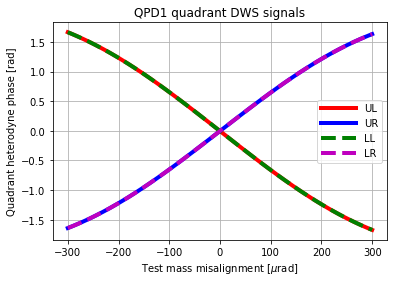

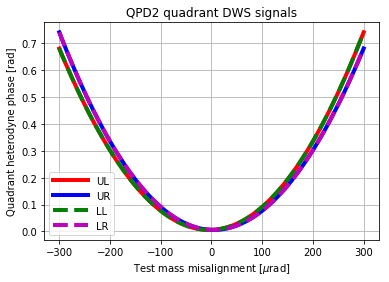

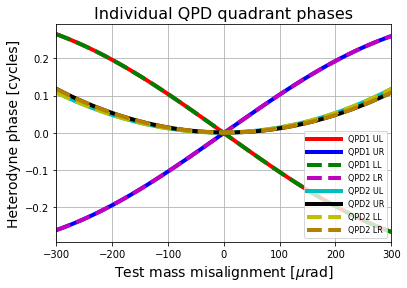

In [14]:
fs=14
tfs=16

DWSyaw={}
spotyaw={}
DWSyaw['QPD1']=pl.zeros(len(angs))
DWSyaw['QPD2']=pl.zeros(len(angs))
spotyaw['QPD1']=pl.zeros(len(angs))
spotyaw['QPD2']=pl.zeros(len(angs))

for pd in pds:

    lw=4
    ms=14
    pl.figure()
    pl.plot((angs+90)*pl.pi/180*1e6,QPDphases[pd]['UL'],'r-',label='UL',linewidth=lw,markersize=ms)
    pl.plot((angs+90)*pl.pi/180*1e6,QPDphases[pd]['UR'],'b-',label='UR',linewidth=lw,markersize=ms)
    pl.plot((angs+90)*pl.pi/180*1e6,QPDphases[pd]['LL'],'g--',label='LL',linewidth=lw,markersize=ms)
    pl.plot((angs+90)*pl.pi/180*1e6,QPDphases[pd]['LR'],'m--',label='LR',linewidth=lw,markersize=ms)
    pl.legend(loc=0,handlelength=3.5)
    pl.grid()
    pl.xlabel('Test mass misalignment [$\mu$rad]')
    pl.ylabel('Quadrant heterodyne phase [rad]')
    pl.title(pd+' quadrant DWS signals')
#     pl.xlim([-100,100])
#     pl.ylim([-0.3,0.3])
    pl.savefig('DWSsigs_'+pd+'.pdf')
    
    DWSyaw[pd]=(QPDphases[pd]['UL']+QPDphases[pd]['LL']-QPDphases[pd]['UR']-QPDphases[pd]['LR'])/4
    spotyaw[pd]=(QPDpows[pd]['UL']+QPDpows[pd]['LL']-QPDpows[pd]['UR']-QPDpows[pd]['LR'])/(QPDpows[pd]['UL']+QPDpows[pd]['LL']+QPDpows[pd]['UR']+QPDpows[pd]['LR'])

pl.figure()
pl.plot((angs+90)*pl.pi/180*1e6,QPDphases['QPD1']['UL']/2/pl.pi,'r-',label='QPD1 UL',linewidth=lw,markersize=ms)
pl.plot((angs+90)*pl.pi/180*1e6,QPDphases['QPD1']['UR']/2/pl.pi,'b-',label='QPD1 UR',linewidth=lw,markersize=ms)
pl.plot((angs+90)*pl.pi/180*1e6,QPDphases['QPD1']['LL']/2/pl.pi,'g--',label='QPD1 LL',linewidth=lw,markersize=ms)
pl.plot((angs+90)*pl.pi/180*1e6,QPDphases['QPD1']['LR']/2/pl.pi,'m--',label='QPD2 LR',linewidth=lw,markersize=ms)
pl.plot((angs+90)*pl.pi/180*1e6,QPDphases['QPD2']['UL']/2/pl.pi,'c-',label='QPD2 UL',linewidth=lw,markersize=ms)
pl.plot((angs+90)*pl.pi/180*1e6,QPDphases['QPD2']['UR']/2/pl.pi,'k',label='QPD2 UR',linewidth=lw,markersize=ms)
pl.plot((angs+90)*pl.pi/180*1e6,QPDphases['QPD2']['LL']/2/pl.pi,'y--',label='QPD2 LL',linewidth=lw,markersize=ms)
pl.plot((angs+90)*pl.pi/180*1e6,QPDphases['QPD2']['LR']/2/pl.pi,color=[0.7,0.5,0],linestyle='--',label='QPD2 LR',linewidth=lw,markersize=ms)
pl.legend(loc=4,handlelength=4.25,fontsize=8)
pl.grid()
pl.xlim([-300,300])
pl.xlabel('Test mass misalignment [$\mu$rad]',fontsize=fs)
pl.ylabel('Heterodyne phase [cycles]',fontsize=fs)
pl.title('Individual QPD quadrant phases',fontsize=tfs)
#     pl.xlim([-100,100])
#     pl.ylim([-0.3,0.3])
pl.savefig('DWSsigs_both.pdf')


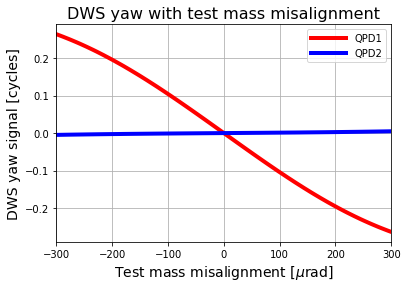

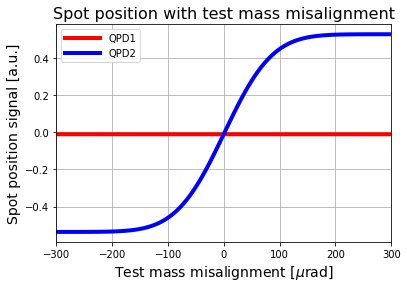

In [15]:

pl.figure()
pl.plot((angs+90)*pl.pi/180*1e6,DWSyaw['QPD1']/2/pl.pi,'r',label='QPD1', linewidth=lw)
pl.plot((angs+90)*pl.pi/180*1e6,DWSyaw['QPD2']/2/pl.pi,'b',label='QPD2', linewidth=lw)
pl.xlabel('Test mass misalignment [$\mu$rad]',fontsize=fs)
pl.ylabel('DWS yaw signal [cycles]',fontsize=fs)
pl.grid()
pl.legend(loc=0,handlelength=3.5)
pl.title('DWS yaw with test mass misalignment',fontsize=tfs)
pl.xlim([-300,300])
pl.savefig('DWSyaw_bothQPDs.pdf')
    #pl.xlim(-0.004,0.004)

pl.figure()
pl.plot((angs+90)*pl.pi/180*1e6,spotyaw['QPD1'],'r',label='QPD1', linewidth=lw)
pl.plot((angs+90)*pl.pi/180*1e6,spotyaw['QPD2'],'b',label='QPD2', linewidth=lw)
pl.xlabel('Test mass misalignment [$\mu$rad]',fontsize=fs)
pl.xlim([-300,300])
pl.ylabel('Spot position signal [a.u.]',fontsize=fs)
pl.grid()
pl.legend(loc=0,handlelength=3.5)
pl.title('Spot position with test mass misalignment',fontsize=tfs)
# pl.xlim([-100,100])
pl.savefig('spotyaw_bothQPDs.pdf')